# Análisis Estadístico Multivariado
# 29 de Noviembre de 2025
# Proyecto final
# Acoyani Garrido Sandoval

## 1. Descripción

Consiste en determinar la relación entre una variable dependiente y una o más variables independientes a través de regresión logística múltiple. Se usará para ello un conjunto de datos de patrones de órdenes de comida rápida en diferentes ciudades de India, desarrollado por Prince Rajak y disponible en [Kaggle](https://www.kaggle.com/datasets/prince7489/fast-food-ordering-pattern-dataset).



In [1]:
import pandas
import numpy
import matplotlib.pyplot as pyplot
import json
import seaborn
import datetime

# Boilerplate: necesitamos un JSON encoder capaz de manejar números de Numpy
class SerializadorJSONParaLaClaseDeTemores(json.JSONEncoder):
   def default(self, objeto):
      # numpy.int64: lo convertimos a un número estándar de Python para que el serializador estándar
      # pueda manejarlo
      if isinstance(objeto, numpy.int64) or isinstance(objeto, numpy.int32):
         return objeto.item()
      # Cualquier otro tipo: usamos el serializador estándar
      else:
         return json.JSONEncoder.default(self, objeto)


# Tomamos la primera columna como índice, porque es un número de ID
df_pedidos = pandas.read_csv("fast_food_ordering_dataset.csv", index_col=0)

## 2. Análisis descriptivo

Comenzamos por desarrollar un análisis descriptivo de las variables del conjunto de datos.

Cada registro de nuestro conjunto de datos es un pedido individual de comida rápida, cuyas variables son:
- **order_id:** Número de pedido
- **order_time:** Fecha y hora del pedido en tiempo de India
- **city:** Ciudad donde fue hecho el pedido
- **cuisine_type:** Estilo de cocina
- **order_value:** Precio del pedido en rupias
- **delivery_time_minutes:** Tiempo del pedido en minutos
- **items_count:** Cuántos elementos tiene el pedido
- **payment_method:** Método de pago:
   - **UPI:** *Unified Payments Interface,* un sistema de pagos electrónicos operado por el banco nacional de India
   - **Wallet:** pagos hechos mediante sistemas orientados a dispositivos móviles, tales como Apple y Google Pay.
   - **Credit Card:** tarjeta de crédito
   - **Debit Card:** tarjeta de débito
   - **Cash:** efectivo

El análisis que haremos incluirá:

1. **Para las variables de razón:** Medidas de tendencia central y de dispersión: moda, media, mediana, rango, desviación estándar, rango intercuartílico, y diagrama de caja.
   - Minutos de entrega
   - Cantidad de elementos
   - Precio
1. **Para la variable de intervalo:** Distribución (histograma), moda y mediana
   - Hora del pedido
1. **Para las variables nominales:** Conteo en gráfica, y porcentaje
   - Ciudad
   - Estilo de cocina
   - Método de pago


In [2]:
# Parte 1: medidas de las variables de razón
variables_razon = [ "delivery_time_minutes", "items_count", "order_value" ]
variables_intervalo = [ "order_time" ]
variables_nominales = [ "city", "cuisine_type", "payment_method" ]

# Medidas de las variables de razón
variables_razon_medidas = {}
for una_variable in variables_razon:
   medidas = \
   {
      "promedio": df_pedidos[una_variable].mean(),
      "mediana": df_pedidos[una_variable].median(),
      "moda": df_pedidos[una_variable].mode()[0],
      "varianza": df_pedidos[una_variable].var(),
      "desvstd": df_pedidos[una_variable].std(),
      "rango": df_pedidos[una_variable].max() - df_pedidos[una_variable].min(),
      "RI": df_pedidos[una_variable].quantile(0.75) - df_pedidos[una_variable].quantile(0.25)
   }
   variables_razon_medidas.update({ una_variable: medidas })

print(f"Medidas de las variables de razón: {json.dumps(variables_razon_medidas, indent=3, cls=SerializadorJSONParaLaClaseDeTemores)}")


Medidas de las variables de razón: {
   "delivery_time_minutes": {
      "promedio": 44.696,
      "mediana": 44.0,
      "moda": 43,
      "varianza": 299.28214829659316,
      "desvstd": 17.29977307066752,
      "rango": 59,
      "RI": 30.25
   },
   "items_count": {
      "promedio": 4.104,
      "mediana": 4.0,
      "moda": 5,
      "varianza": 3.8208256513026053,
      "desvstd": 1.9546932371353325,
      "rango": 6,
      "RI": 4.0
   },
   "order_value": {
      "promedio": 630.14666,
      "mediana": 619.0,
      "moda": 105.1,
      "varianza": 98622.8453276998,
      "desvstd": 314.04274442772885,
      "rango": 1094.5900000000001,
      "RI": 546.9575
   }
}


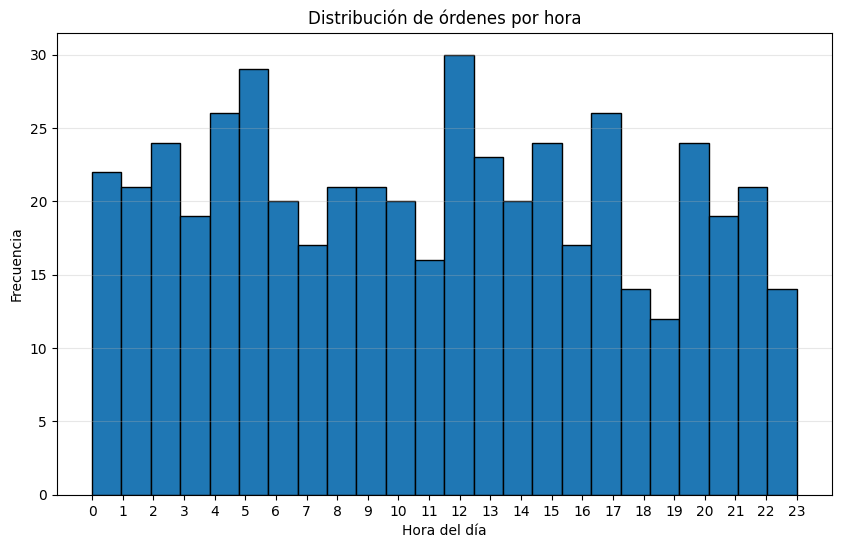

Medidas de la variable de intervalo: {
   "order_time": {
      "moda": 12,
      "mediana": 11.0
   }
}


In [3]:
# Parte 2: medidas de la variable de intervalo: moda y mediana
variables_intervalo_medidas = {}

# Convertimos order_time a datetime.datetime y extraemos la hora
df_pedidos["order_time"] = pandas.to_datetime(df_pedidos["order_time"])
order_time_datetime = df_pedidos["order_time"].dt.hour

# Sacamos moda y mediana
hora_moda = order_time_datetime.mode()[0]
hora_mediana = order_time_datetime.median()

# Sacamos un histograma de pedidos por hora
pyplot.figure(figsize=(10, 6))
pyplot.hist(order_time_datetime, bins=24, edgecolor='black')
pyplot.xlabel('Hora del día')
pyplot.ylabel('Frecuencia')
pyplot.title('Distribución de órdenes por hora')
pyplot.xticks(range(0, 24))
pyplot.grid(axis='y', alpha=0.3)
pyplot.show()

# Guardamos nuestras medidas
variables_intervalo_medidas["order_time"] = {
   "moda": hora_moda,
   "mediana": hora_mediana
}

print(f"Medidas de la variable de intervalo: {json.dumps(variables_intervalo_medidas, indent=3, cls=SerializadorJSONParaLaClaseDeTemores)}")


In [10]:
# Parte 3: medidas de las variables nominales
# Sacamos conteo y porcentaje
variables_nominales_medidas = {}

for una_variable in variables_nominales:
   medidas = \
   {
      "conteos": {},
      "porcentajes": {}
   }

   # En cada variable, sacamos los datos únicos
   valores_nominales = list(numpy.unique(numpy.array(df_pedidos[una_variable])))
   
   # Luego sacamos cuánto hay de cada valor único
   # De una vez sacamos el total
   sumatoria = 0
   for un_valor in valores_nominales:
      columna = df_pedidos[una_variable]
      columna_filtrada = columna[ columna == un_valor ]
      medidas["conteos"].update({ un_valor: len(columna_filtrada)})
      sumatoria += len(columna_filtrada)
   
   # Luego sacamos los porcentajes (del 0 al 1)
   for clave, valor in medidas["conteos"].items():
      medidas["porcentajes"].update({ clave: float(valor) / sumatoria })

   # Revisamos el resultado y lo incorporamos
   variables_nominales_medidas.update({ una_variable: medidas })

print(f"Medidas de las variables nominales: {json.dumps(variables_nominales_medidas, indent=3, cls=SerializadorJSONParaLaClaseDeTemores)}")


Medidas de las variables nominales: {
   "city": {
      "conteos": {
         "Ahmedabad": 72,
         "Bengaluru": 64,
         "Chennai": 51,
         "Delhi": 46,
         "Hyderabad": 76,
         "Kolkata": 62,
         "Mumbai": 71,
         "Pune": 58
      },
      "porcentajes": {
         "Ahmedabad": 0.144,
         "Bengaluru": 0.128,
         "Chennai": 0.102,
         "Delhi": 0.092,
         "Hyderabad": 0.152,
         "Kolkata": 0.124,
         "Mumbai": 0.142,
         "Pune": 0.116
      }
   },
   "cuisine_type": {
      "conteos": {
         "Bakery": 51,
         "Chinese": 49,
         "Fast Food": 74,
         "Healthy": 61,
         "Italian": 70,
         "Mexican": 62,
         "North Indian": 62,
         "South Indian": 71
      },
      "porcentajes": {
         "Bakery": 0.102,
         "Chinese": 0.098,
         "Fast Food": 0.148,
         "Healthy": 0.122,
         "Italian": 0.14,
         "Mexican": 0.124,
         "North Indian": 0.124,
         "

C:\Users\Midriffy\AppData\Local\Temp\ipykernel_19244\1598830009.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  seaborn.barplot(x=conteos, y=valores, palette="viridis", ax=eje_0)
C:\Users\Midriffy\AppData\Local\Temp\ipykernel_19244\1598830009.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  seaborn.barplot(x=porcentajes, y=valores, palette="magma", ax=eje_1)


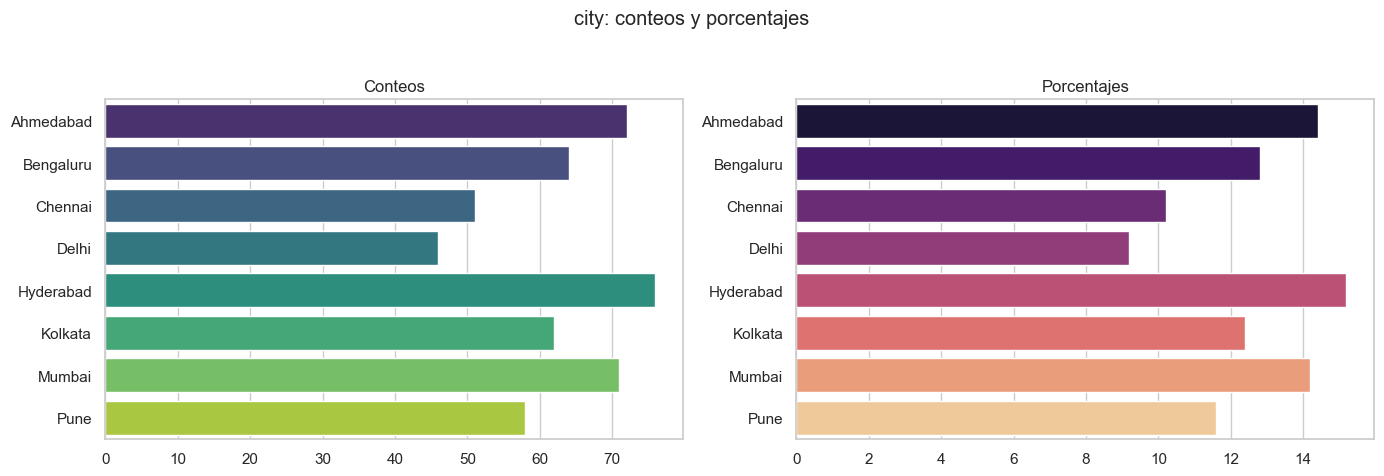

C:\Users\Midriffy\AppData\Local\Temp\ipykernel_19244\1598830009.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  seaborn.barplot(x=conteos, y=valores, palette="viridis", ax=eje_0)
C:\Users\Midriffy\AppData\Local\Temp\ipykernel_19244\1598830009.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  seaborn.barplot(x=porcentajes, y=valores, palette="magma", ax=eje_1)


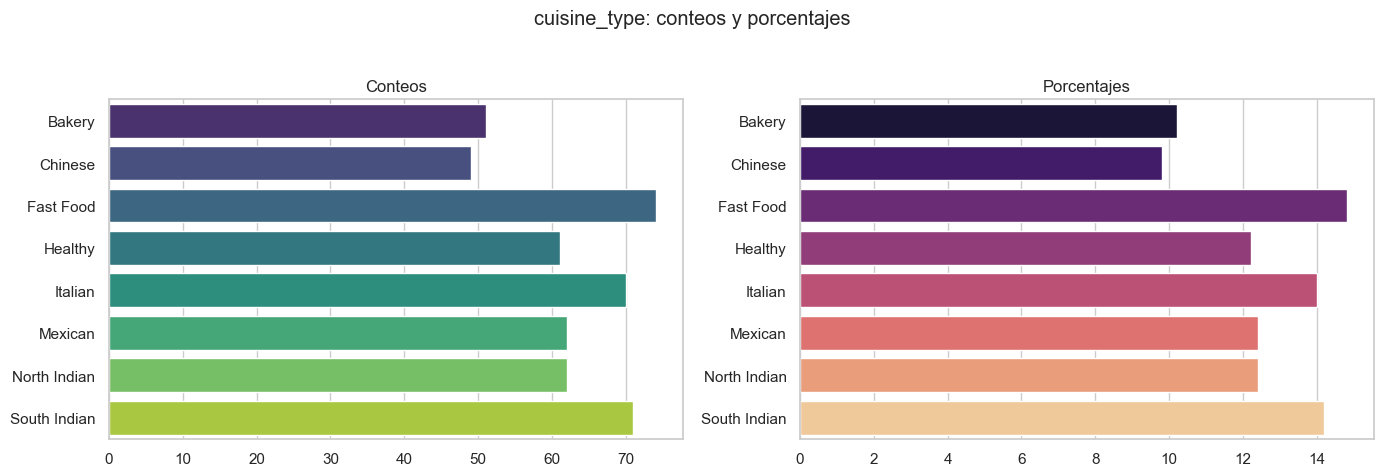

C:\Users\Midriffy\AppData\Local\Temp\ipykernel_19244\1598830009.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  seaborn.barplot(x=conteos, y=valores, palette="viridis", ax=eje_0)
C:\Users\Midriffy\AppData\Local\Temp\ipykernel_19244\1598830009.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  seaborn.barplot(x=porcentajes, y=valores, palette="magma", ax=eje_1)


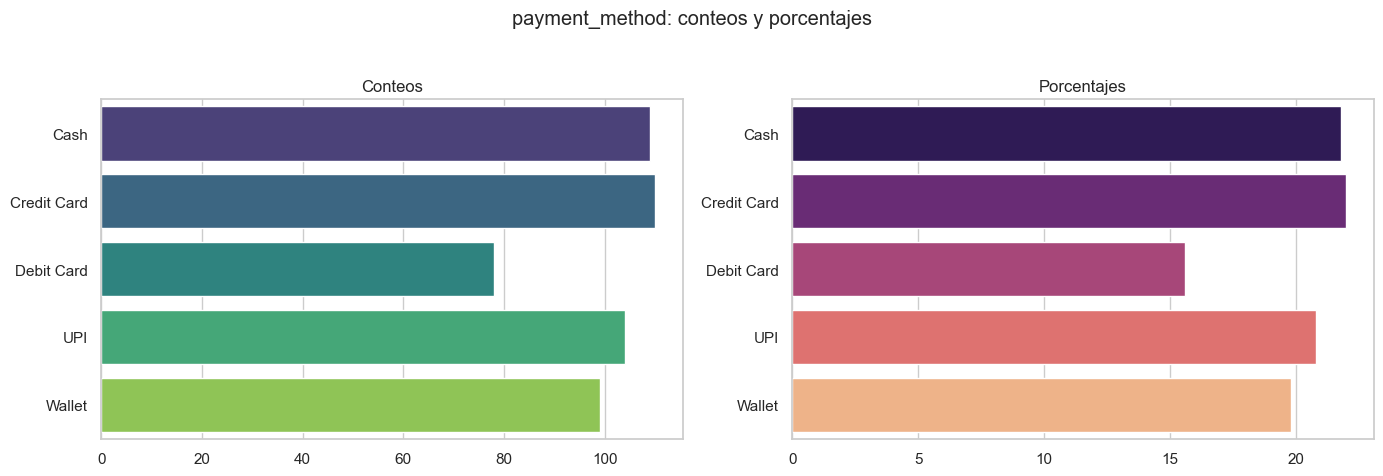

In [18]:
# Graficamos el paso anterior
for una_variable in variables_nominales:
   medidas = variables_nominales_medidas[una_variable]
   conteos = [ valor for _, valor in medidas["conteos"].items() ]
   porcentajes = [ porcentaje * 100 for _, porcentaje in medidas["porcentajes"].items() ]
   valores = [ clave for clave, _ in medidas["conteos"].items() ]

   # Creamos una gráfica de 14 x 5 "pulgadas"
   figura, ejes = pyplot.subplots(1, 2, figsize=(14,5))
   figura.suptitle(f"{una_variable}: conteos y porcentajes")

   eje_0 = ejes[0]
   seaborn.barplot(x=conteos, y=valores, palette="viridis", ax=eje_0)
   eje_0.set_title("Conteos")

   eje_1 = ejes[1]
   seaborn.barplot(x=porcentajes, y=valores, palette="magma", ax=eje_1)
   eje_1.set_title("Porcentajes")

   # Pyplot por sí mismo no acomoda bien las dimensiones de las etiquetas
   # Para eso, usamos tight_layout. El parámetro rect indica cuánto debe abarcar el contenido de la
   # gráfica.
   pyplot.tight_layout(rect=[0, 0.03, 1, 0.95])
   pyplot.show()


C:\Users\Midriffy\AppData\Local\Temp\ipykernel_19244\2536741370.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteos.values, y=conteos.index, palette="viridis", ax=ax0)
C:\Users\Midriffy\AppData\Local\Temp\ipykernel_19244\2536741370.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=porcentajes.values, y=porcentajes.index, palette="magma", ax=ax1)


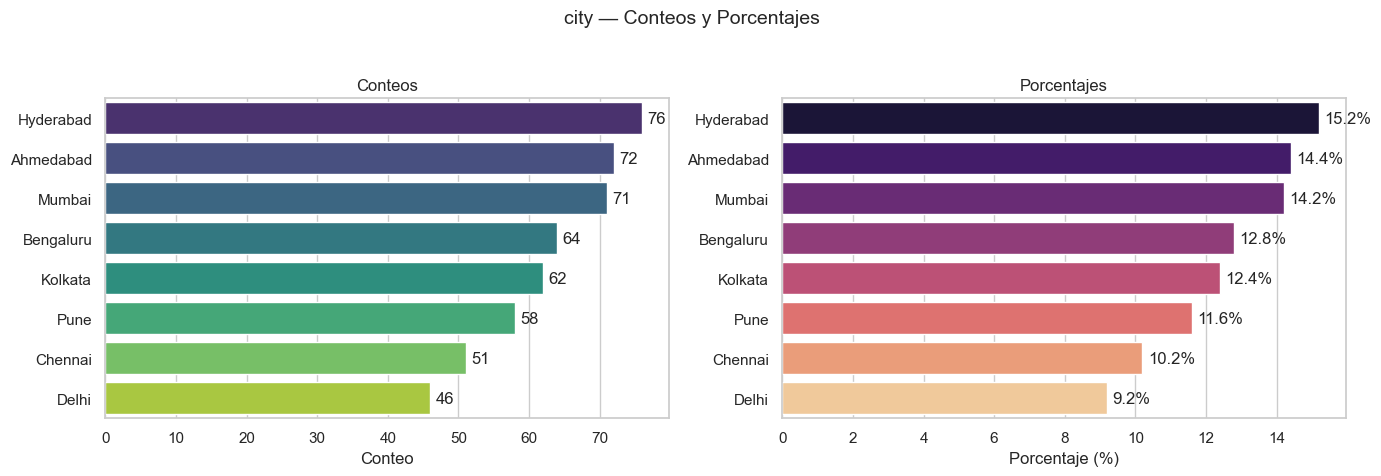

C:\Users\Midriffy\AppData\Local\Temp\ipykernel_19244\2536741370.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteos.values, y=conteos.index, palette="viridis", ax=ax0)
C:\Users\Midriffy\AppData\Local\Temp\ipykernel_19244\2536741370.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=porcentajes.values, y=porcentajes.index, palette="magma", ax=ax1)


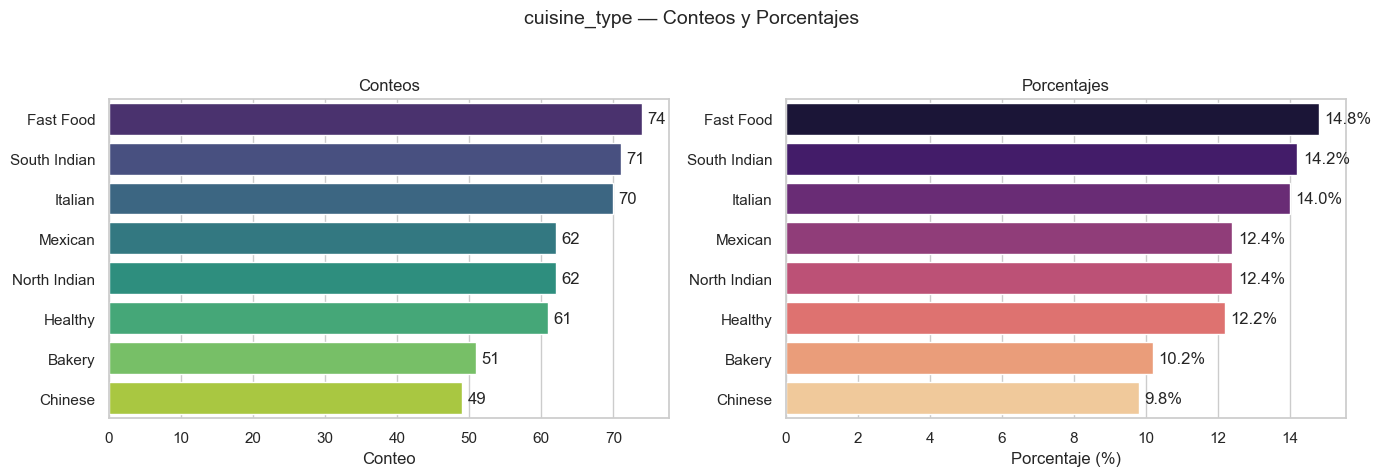

C:\Users\Midriffy\AppData\Local\Temp\ipykernel_19244\2536741370.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteos.values, y=conteos.index, palette="viridis", ax=ax0)
C:\Users\Midriffy\AppData\Local\Temp\ipykernel_19244\2536741370.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=porcentajes.values, y=porcentajes.index, palette="magma", ax=ax1)


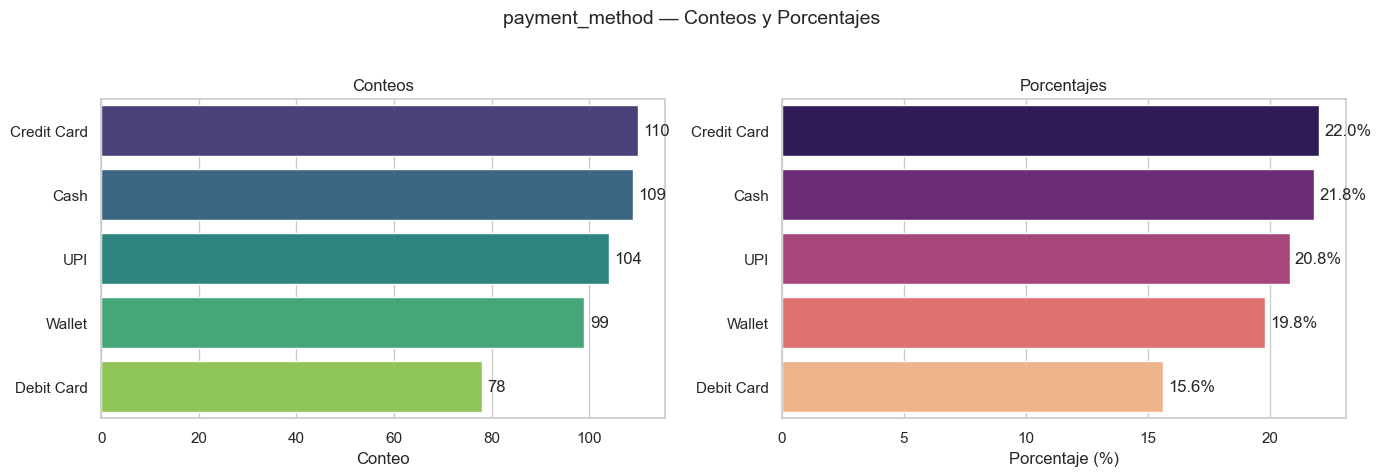

In [11]:
import seaborn as sns
import pandas as pd


# Graficar conteos y porcentajes para variables nominales usando los resultados ya calculados
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

for var in variables_nominales:
   # Tomamos conteos y porcentajes desde variables_nominales_medidas
   conteos = pd.Series(variables_nominales_medidas[var]["conteos"])
   porcentajes = pd.Series(variables_nominales_medidas[var]["porcentajes"])
   # Orden consistente: descendente por conteos
   conteos = conteos.sort_values(ascending=False)
   porcentajes = porcentajes.reindex(conteos.index) * 100.0  # pasar a porcentaje (0-100)

   fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={"width_ratios": [1, 1]})
   fig.suptitle(f"{var} — Conteos y Porcentajes", fontsize=14)

   # Panel 1: Conteos (barras horizontales)
   ax0 = axes[0]
   sns.barplot(x=conteos.values, y=conteos.index, palette="viridis", ax=ax0)
   ax0.set_xlabel("Conteo")
   ax0.set_ylabel("")
   ax0.set_title("Conteos")
   # Etiquetas de valor en las barras
   for i, v in enumerate(conteos.values):
      ax0.text(v + max(conteos.values) * 0.01, i, str(int(v)), va='center')

   # Panel 2: Porcentajes (barras horizontales)
   ax1 = axes[1]
   sns.barplot(x=porcentajes.values, y=porcentajes.index, palette="magma", ax=ax1)
   ax1.set_xlabel("Porcentaje (%)")
   ax1.set_ylabel("")
   ax1.set_title("Porcentajes")
   for i, v in enumerate(porcentajes.values):
      ax1.text(v + max(porcentajes.values) * 0.01, i, f"{v:.1f}%", va='center')

   plt.tight_layout(rect=[0, 0.03, 1, 0.95])
   plt.show()